##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

## Setup

In [1]:
!pip install -q tensorflow_datasets

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](../load_data/text.ipynb) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This may be the worst show I\'ve ever seen. Aside from the tastelessness of having a sitcom about Hitler, it just isn\'t funny or entertaining in any way. It is very similar to a 1950\'s sitcom in its cornball humor and contrived situations, but while it can be well done like in I Love Lucy, it\'s just not funny here. I think the show was based around the novelty "look, it\'s Hitler as a bumbling sitcom figure" but it just fell flat in every regard. The guy playing Hitler is so hammy that its hard to sit through that alone. I wonder what could have possibly made the network think this was a good idea to air. I thought America had some tasteless show, but the Brits had us beat this time. America would never air a sitcom about Hitler, although we did have that show about Lincoln\'s slave, The Secret Diary of Desmond Pfeiffer. Chances are you\'ll probably never see this show, since it only aired one episode and will probably never be released on DVD.'
 b'This movie should not c

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 194,  28, ...,   0,   0,   0],
       [ 11,  18, 139, ...,   0,   0,   0],
       [ 10,   1,  11, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasns for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This may be the worst show I\'ve ever seen. Aside from the tastelessness of having a sitcom about Hitler, it just isn\'t funny or entertaining in any way. It is very similar to a 1950\'s sitcom in its cornball humor and contrived situations, but while it can be well done like in I Love Lucy, it\'s just not funny here. I think the show was based around the novelty "look, it\'s Hitler as a bumbling sitcom figure" but it just fell flat in every regard. The guy playing Hitler is so hammy that its hard to sit through that alone. I wonder what could have possibly made the network think this was a good idea to air. I thought America had some tasteless show, but the Brits had us beat this time. America would never air a sitcom about Hitler, although we did have that show about Lincoln\'s slave, The Secret Diary of Desmond Pfeiffer. Chances are you\'ll probably never see this show, since it only aired one episode and will probably never be released on DVD.'
Round-trip:  this may be

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.02044006]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.02044006]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [119]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 334s 854ms/step - loss: 0.3957 - accuracy: 0.8120 - val_loss: 0.3847 - val_accuracy: 0.8323
Epoch 2/10
391/391 [==============================] - 346s 885ms/step - loss: 0.3527 - accuracy: 0.8464 - val_loss: 0.3631 - val_accuracy: 0.8339
Epoch 3/10
391/391 [==============================] - 347s 888ms/step - loss: 0.3337 - accuracy: 0.8551 - val_loss: 0.3540 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 344s 880ms/step - loss: 0.3209 - accuracy: 0.8612 - val_loss: 0.3319 - val_accuracy: 0.8536
Epoch 5/10
391/391 [==============================] - 348s 890ms/step - loss: 0.3112 - accuracy: 0.8661 - val_loss: 0.3270 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 348s 890ms/step - loss: 0.3061 - accuracy: 0.8694 - val_loss: 0.3251 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 348s 891ms/step - loss: 0.3036 - accuracy: 0.8710 - val_loss: 0.3221 -

In [120]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 94s 239ms/step - loss: 0.3171 - accuracy: 0.8620
Test Loss: 0.3170832097530365
Test Accuracy: 0.8620399832725525


(0.0, 0.40068761110305784)

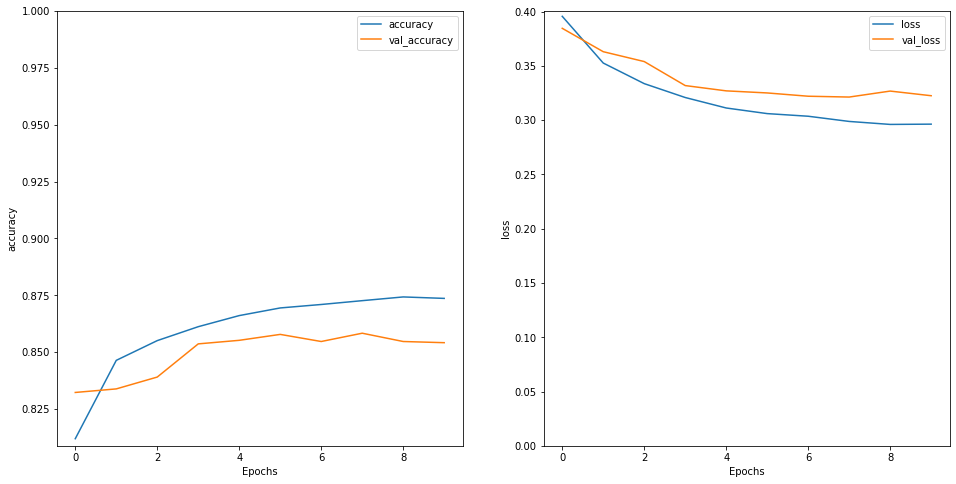

In [121]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

Run a prediction on a neew sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [124]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.74505585]], dtype=float32)

---

## Explanation

In [126]:
from anchor import anchor_text
import spacy

In [127]:
nlp = spacy.load('en_core_web_lg')

In [128]:
explainer = anchor_text.AnchorText(nlp, ['negative','positive'], use_unk_distribution=True)

In [129]:
# this is the requested function by Anchors!

def predict_text(text):
    return model.predict(text)[0]

def predict_text_alias(text):
    prediction = model.predict(np.array([text]))
    return "positive" if prediction[0][0] >= 0 else "negative"


In [130]:
text = 'terribly film became uncertainly positive'
pred = explainer.class_names

In [131]:
pred

['negative', 'positive']

In [138]:
text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

In [133]:
text = 'The movie was out of this world'

In [141]:
exp = explainer.explain_instance(text, predict_text, threshold=0.8, verbose=False, use_proba=True)

In [142]:
' AND '.join(exp.names())

'. AND this AND world AND this AND out AND The AND graphics AND The AND movie AND was AND I AND of AND . AND were AND cool AND movie AND would AND animation AND and AND the AND . AND recommend'

In [136]:
exp.examples()

array([['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world'],
       ['The movie was out of this world']], dtype='<U80')

In [137]:
model.predict(np.array([text]))

array([[0.4078989]], dtype=float32)

---